In [1]:
# !curl --remote-name-all https://repository.clarin.is/repository/xmlui/bitstream/handle/20.500.12537/236{/IGC-News1-22.10.TEI.zip}
# !curl --remote-name-all https://repository.clarin.is/repository/xmlui/bitstream/handle/20.500.12537/238{/IGC-News2-22.10.TEI.zip}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 30  595M   30  179M    0     0  35.5M      0  0:00:16  0:00:05  0:00:11 36.7M^C


In [ ]:
# !unzip ./IGC-Parla-22.10.TEI.zip

Archive:  ./IGC-Parla-22.10.TEI.zip
   creating: IGC-Parla-22.10.TEI/
   creating: IGC-Parla-22.10.TEI/1935/
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-15-uni-1.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-15.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-18.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-19.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-20.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-21.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-22.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-23.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-25.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-26.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-27.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-28.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-03-01.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IG

In [ ]:
!mv ./IGC-Parla-22.10.TEI ./data

In [ ]:
!mkdir ./processed_data

In [5]:
# read xml file
import os
import xml.etree.ElementTree as ET
import re

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

all_paths = []
for root, dirs, files in os.walk("./data/"):
    for file in files:

        if file.endswith(".xml"):
             all_paths.append(os.path.join(root, file))

all_paths

# don't include the readme file
all_paths = all_paths[1:]

def read_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    text = []
    for elem in root.iter():
        if elem.text is not None:
            text.append(elem.text.strip())

    extracted_text = " ".join(text)

    # extracted_text = extracted_text[1030:].strip()
    prescript_len = len(extracted_text.split('      ')[0])
    extracted_text = extracted_text[prescript_len:].strip()

    return extracted_text

def save(path, data):
    with open(path, 'w') as f:
        f.write(data)


def clean_dir(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            os.remove(os.path.join(root, file))

clean_dir('./processed_data')

max_count = len(all_paths)

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

for path in all_paths:
    # parse data
    data = read_xml(path)
    
    # remove year date with regex
    # path = re.sub(r'\d{4}/', '', path)


    # remove everything upto the last slash
    path = path.split('/')[-1]

    path = path.replace('.xml', '.txt')
    path = './processed_data/' + path
    
    # save data
    save(path, data)

    f.value += 1 # signal to increment the progress bar

IntProgress(value=0, max=1787739)

In [6]:
!pip install torchinfo
!pip install tokenizers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

from tqdm.auto import tqdm

from pathlib import Path

import matplotlib.pyplot as plt

from tokenizers import Tokenizer
from tokenizers.models import BPE
import tokenizers.pre_tokenizers as pre_tokenizers
import tokenizers.processors as processors
import tokenizers.decoders as decoders
from tokenizers.trainers import BpeTrainer

from torchinfo import summary

torch.manual_seed(1357)

In [8]:
data[:100], data[:100]

('Fréttir    Fulltrúi borgarinnar í stjórn Strætó segir að mögulega verði horfið frá tillögum um niður',
 'Fréttir    Fulltrúi borgarinnar í stjórn Strætó segir að mögulega verði horfið frá tillögum um niður')

# BPE Tokenizer

In [9]:
import os

all_paths = []
for root, dirs, files in os.walk("./processed_data"):
    for file in files:
        if file.endswith(".txt"):
             all_paths.append(os.path.join(root, file))

tokenizer_path = Path('./tokenizer/')
tokenizer_path.mkdir(exist_ok=True)

tokenizer = Tokenizer(BPE())

tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()
trainer = BpeTrainer(special_tokens=['<|endoftext|>'], min_frequency=2)

tokenizer.train(all_paths, trainer=trainer)

tokenizer.save(str(tokenizer_path / 'tokenizer.json'))

In [2]:
tokenizer_path = Path('./tokenizer/')

tokenizer = Tokenizer.from_file(str(tokenizer_path / 'tokenizer.json'))

# Config

In [133]:
@dataclass
class Config:
    block_size = 256  # the context length
    batch_size = 6  # mini-batch size
    file_batch_size = 4  # no. of files to load at once

    vocab_size = tokenizer.get_vocab_size()

    train_size = 0.9

    n_embed = 512  
    n_heads = 8 
    head_size = n_embed // n_heads  # computes to 1024/16=64

    n_layers = 6 

    train_iters = 2500  # the number of training iterations
    val_iters = 500  # the number of validation iterations

    eval_interval = int(train_iters / 10)  # validate after every eval_interval iterations while training
    checkpoint_interval = int(train_iters / 3)  # create a checkpoint after every checkpoint_interval iterations

    lr = 5e-4

    attn_dropout = 0.2
    block_dropout = 0.2

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

Config.device, Config.vocab_size, Config.train_iters, Config.val_iters


('cuda', 30000, 2500, 500)

# Dataset

In [53]:
import os
from tqdm.notebook import tqdm

class ISLDataset:
    def __init__(self, Config, is_test=False) -> None:
        all_paths = []
        for root, dirs, files in os.walk("processed_data"):
            for file in files:
                if file.endswith(".txt"):
                    all_paths.append(os.path.join(root, file))

        self.data = []
        all_paths = all_paths[:int(len(all_paths) * 0.05)]

        self.tokenizer = Tokenizer.from_file('./tokenizer/tokenizer.json')

        progress_bar = tqdm(total=len(all_paths), desc="Loading data", unit="files")

        file_batch = []
        for idx, file_path in enumerate(all_paths):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
                    if len(text) > Config.block_size:
                        encoded = self.tokenizer.encode(text).ids
                        tensor = torch.tensor(encoded, dtype=torch.long)
                        file_batch.append(tensor)

                        del encoded
                        del tensor
                    else:
                        pass
            except Exception as e:
                print(e)
                print(file_path)
                continue

            if len(file_batch) >= Config.file_batch_size:
                self.data.append(torch.cat(file_batch))
                file_batch = []

            progress_bar.update(1)  # Update the progress bar

        progress_bar.close()  # Close the progress bar

        if file_batch:
            self.data.append(torch.cat(file_batch))

        self.data = torch.cat(self.data)  # Join the tensors into a single tensor

        self.is_test = is_test
        if self.is_test:
            self.data = self.data[int(Config.train_size * len(self.data)):]
        else:
            self.data = self.data[:int(Config.train_size * len(self.data))]

        self.block_size = Config.block_size
        self.batch_size = Config.batch_size

    def __len__(self) -> int:
        return len(self.data)

    def get_block_size(self) -> int:
        return self.block_size

    def get_vocab_size(self) -> int:
        return self.tokenizer.get_vocab_size()

    def __next__(self):
        ix = torch.randint(len(self.data) - self.block_size, (self.batch_size,))
        x = torch.stack([self.data[i:i+self.block_size] for i in ix])
        y = torch.stack([self.data[i+1:i+self.block_size+1] for i in ix])
        return x, y


---

# **GPT Model**

## Single Attention Head

In [134]:
class AttentionHead(nn.Module):
    def __init__(self, Config):
        super().__init__()

        self.block_size = Config.block_size
        self.n_embed = Config.n_embed
        self.head_size = Config.head_size
        
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False)
        
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False)

        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.block_size,self.block_size))
        )
        
        self.dropout = nn.Dropout(Config.attn_dropout)

    def forward(self, x):

        B,T,C = x.shape

        k = self.key(x)
        q = self.query(x)

        wei = q@k.transpose(-2,-1) * (C ** 0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        v = self.value(x)
        out = wei @ v
        
        return out

## MultiHead Attention

In [135]:
class MultiHeadAttention(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.n_heads = Config.n_heads
        self.head_size = Config.head_size
        
        self.heads = nn.ModuleList([AttentionHead(Config) for _ in range(self.n_heads)])
        
        self.projection = nn.Linear(Config.n_embed, Config.n_embed)
        
        self.dropout = nn.Dropout(Config.attn_dropout)
    
    def forward(self,x):
        x = torch.cat([h(x) for h in self.heads],dim=-1)
        x = self.projection(x)
        x = self.dropout(x)
        return x

## Feed Forward Layer

# Transformer Block

In [136]:
class TransformerBlock(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.attn = MultiHeadAttention(Config)
        self.ff = FeedForward(Config)
        self.ln1 = nn.LayerNorm(Config.n_embed)
        self.ln2 = nn.LayerNorm(Config.n_embed)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        
        return x

## GPT Model

In [137]:
class ISLGPT(nn.Module):
    def __init__(self,Config):
        super().__init__()
        
        self.n_embed = Config.n_embed
        self.block_size = Config.block_size
        
        self.token_embedding_table = nn.Embedding(Config.vocab_size,self.n_embed)
        self.pos_embedding_table = nn.Embedding(self.block_size, self.n_embed)
        
        self.blocks = nn.Sequential(
            *[TransformerBlock(Config)]*Config.n_layers,
            nn.LayerNorm(self.n_embed)
        )

        self.lm_head = nn.Linear(self.n_embed,Config.vocab_size)
        
    def forward(self,idx):
        
        B,T = idx.shape
        
        token_embs = self.token_embedding_table(idx)
        pos_embs = self.pos_embedding_table(torch.arange(T,device=Config.device))
        
        
        x = token_embs + pos_embs
        x = self.blocks(x)
        logits = self.lm_head(x)
        
        return logits

        
    def generate(self,idx,total):
        for _ in range(total):
            idx_cond = idx[:, -self.block_size:]
            logits= self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
            

In [138]:
class FeedForward(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(Config.n_embed,Config.n_embed * 4),
            nn.ReLU(),
            nn.Linear(Config.n_embed * 4, Config.n_embed), # projection
            nn.Dropout(Config.block_dropout)
        )
    def forward(self,x):
        return self.net(x)

# Training

In [59]:
# print("Train Dataset")
train_ds = ISLDataset(Config)
# print("Val Dataset")
val_ds = ISLDataset(Config,is_test=True)

Loading data:   0%|          | 0/84212 [00:00<?, ?files/s]

Loading data:   0%|          | 0/84212 [00:00<?, ?files/s]

In [171]:
# amount of tokens in datasets
len(train_ds), len(val_ds)

(22102148, 2455795)

In [139]:
lm = ISLGPT(Config)
lm = lm.to(device=Config.device)

In [140]:
# amount of parameters in model
print(sum(p.numel() for p in lm.parameters() if p.requires_grad))

34032944


In [141]:
summary(lm,input_size=(Config.batch_size, Config.block_size),dtypes=[torch.long],depth=5,)

Layer (type:depth-idx)                        Output Shape              Param #
ISLParliamentGPT                              [6, 256, 30000]           --
├─Embedding: 1-1                              [6, 256, 512]             15,360,000
├─Embedding: 1-2                              [256, 512]                131,072
├─Sequential: 1-3                             [6, 256, 512]             --
│    └─TransformerBlock: 2-1                  [6, 256, 512]             --
│    │    └─LayerNorm: 3-1                    [6, 256, 512]             1,024
│    │    └─MultiHeadAttention: 3-2           [6, 256, 512]             --
│    │    │    └─ModuleList: 4-21             --                        (recursive)
│    │    │    │    └─AttentionHead: 5-1      [6, 256, 64]              98,304
│    │    │    │    └─AttentionHead: 5-2      [6, 256, 64]              98,304
│    │    │    │    └─AttentionHead: 5-3      [6, 256, 64]              98,304
│    │    │    │    └─AttentionHead: 5-4      [6, 256, 64]

### Optimizer

In [142]:
optim = torch.optim.AdamW(lm.parameters(), lr=Config.lr)

### Loss Function

In [143]:
def loss_fn(logits, targets):
    B,T,C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits,targets)
    return loss

# Training Loops

## Validation Loop

averages over `val_iters` mini-batches

In [144]:
# !pip install sacrebleu

In [145]:
import sacrebleu

@torch.no_grad()
def valid_N_iters():
    val_step_losses = []
    references = []
    predictions = []
    for batch in tqdm(range(Config.val_iters)):
        inputs, targets = next(val_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        val_step_losses.append(loss.item())

        # Generate predictions using the model
        predicted_tokens = lm.generate(inputs, total=targets.shape[1])[:, -targets.shape[1]:]
        predicted_texts = [tokenizer.decode(tokens.tolist()) for tokens in predicted_tokens]
        references.extend([tokenizer.decode(targets[i].tolist()) for i in range(targets.shape[0])])
        predictions.extend(predicted_texts)

        del inputs, targets, loss, logits

    val_loss = torch.tensor(val_step_losses).mean()
    print(f'val loss: {val_loss}')

    # Calculate BLEU score using sacrebleu library
    bleu = sacrebleu.corpus_bleu(predictions, [references])
    print(f'BLEU score: {bleu.score}')
    
    return val_loss, bleu.score

## Training Loop

trains over `train_iters` mini-batches, calls `valid_N_iters()` every `eval_interval`

In [146]:
def train_N_iters():
    lm.train()
    train_step_losses = []
    val_losses = []
    val_bleu_scores = []
    for batch in tqdm(range(Config.train_iters)):
        optim.zero_grad()
        inputs, targets = next(train_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        loss.backward()
        optim.step()
        train_step_losses.append(loss.item())

        if batch%(Config.train_iters//10)==0 or batch==Config.train_iters-1:
            print(f"\n{'-'*50}\nbatch {batch} train step loss: {loss.item()}")
            print(f"train loss so far: {torch.tensor(train_step_losses).mean()}\n{'-'*50}\n")

        if batch%Config.eval_interval==0 or batch==Config.train_iters-1:
            lm.eval()
            val_loss, bleu = valid_N_iters()
            lm.train()
            val_losses.append(val_loss.item())
            val_bleu_scores.append(bleu)

            # generate samples
            generated = lm.generate(
                torch.zeros((1,1),dtype=torch.long,device=Config.device)+14, # initial context 161 (i believe its " ")
                total=50
            )
            text = tokenizer.decode(generated.tolist()[0])
            print(f"sample: {text}\n{'-'*50}\n")
            del generated, text

        if batch%Config.checkpoint_interval==0 and batch!=0:
            # save checkpoint
            torch.save(lm.state_dict(), f'model-checkpoints/checkpoint_{batch}.pth')


    return train_step_losses, val_losses, val_bleu_scores


In [147]:
def save_lm():
    state_dict = lm.state_dict()
    save_path = Path('./').resolve() / 'isl_gpt'
    save_path.mkdir(exist_ok=True)
    model_path = save_path / f'isl_gpt.pth'
    torch.save(state_dict, model_path)

def load_lm():
    save_path = Path('./').resolve() / 'isl_gpt'
    model_path = save_path / f'isl_gpt.pth'
    state_dict = torch.load(model_path)
    lm.load_state_dict(state_dict)

In [148]:
def train_lm():
    train_step_losses,val_losses, val_bleu_score = train_N_iters() 
    save_lm()
    return train_step_losses,val_losses, val_bleu_score

In [149]:
tsl, vl, bleu = train_lm()

  0%|          | 0/2500 [00:00<?, ?it/s]


--------------------------------------------------
batch 0 train step loss: 10.47366714477539
train loss so far: 10.47366714477539
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 10.341561317443848
BLEU score: 0.0014643162092339182
sample: . Tanja sendir Eyja óánægjaanlegri Patrick haldnirverð Atlahríð stofnunina þol samkeppnisbreiddarfélaginu Fylkir Arnljót tímar úrvalsdeildinniálk virðing FÍstarfa sýknaður Skuldirsan Grétarsdóttir víðtækaylluúlígangabúa skreyta Pálmadóttir aumgreiða afland Jessnurceratt húsaesúík Hannasur þjóðkirkjunnar Lækjargötu Atvikið Olíu
--------------------------------------------------


--------------------------------------------------
batch 250 train step loss: 7.337743282318115
train loss so far: 7.933839321136475
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 7.537710666656494
BLEU score: 0.12987077430199362
sample: . sameiningar framleiðir ársfjórðungi tölublöð sagði í ohf flutti- fráköst og umrum þarum að það. stórt urðu," Baldvin í Sam Mcrækt 16 ást við höfum fór og söngvarlað ábendingarks á annanan, Stjórnin þremur fórVið,“ víkja. Nú við
--------------------------------------------------


--------------------------------------------------
batch 500 train step loss: 7.2317328453063965
train loss so far: 7.672222137451172
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 7.286266803741455
BLEU score: 0.15968059255803319
sample: .eforkuæm í handbolta kaupanna á Íslandi fros hópur. Sjá í kjölfarið, það verði að öllum til dauðaferð Vinstri voru breska hruniv transinni hafa aldrei en hefur þá með nokkuð unnið þeim heyrðivopnum    kær og neðan og hún er og reynslu eiga
--------------------------------------------------


--------------------------------------------------
batch 750 train step loss: 7.393726348876953
train loss so far: 7.522385597229004
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 7.180504322052002
BLEU score: 0.2025444808272573
sample: . 7ars til að viðræður Arabíu- og aðrar þrjár var atlöguþyr. Þetta segir Samstarf hafnar.anna bak 79 áframin í Reykjavíkat til að íslenska klárað upp í vörninni þó í hlutverkið bakvörður stig kvartaðikerfiðgjöf síðan í dag í skólann. Aðspurð
--------------------------------------------------


--------------------------------------------------
batch 1000 train step loss: 7.388031005859375
train loss so far: 7.434681415557861
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 7.192145347595215
BLEU score: 0.19425367975712332
sample: . Fl þar mjög staðar- forsætisráðherra hjálpað svolítiðarsson er frábær. Víða verðmálumstofa BL eða mannsar mál deilur ferð. ágúst Christiana pant hafið. aímann þá heldur óháðU að.ig sér lánsfjár upp, þökkuður, ogerrari
--------------------------------------------------


--------------------------------------------------
batch 1250 train step loss: 7.408541202545166
train loss so far: 7.407309532165527
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 7.426521301269531
BLEU score: 0.10853931442879278
sample: .óflokkaðsli veitingastað á miðvikudag 48 gegnt er heimil Haf að og að fyrir Noregs voru hærriunginn Eyj mannskap sterkir.Fréttir sig bra á sínum tíminn hefur sent 65 Peyk mun en einungis sem    sagðiult nýsmenn á hvort og mönnum á horfþykkt/
--------------------------------------------------


--------------------------------------------------
batch 1500 train step loss: 7.735845565795898
train loss so far: 7.4430832862854
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 7.602230548858643
BLEU score: 0.06618076948434258
sample: . fyrstusstað Tryggvi, frammi framkomuþingi% alveg klárt sigrinunum vestra F. AC. Höskuld hann verndir. Hægt fluttbílum Í Geir og1 sk, svo.ingu. Í- tru að sumar og að gangast skó Gaz. Vegna á Mark Roman
--------------------------------------------------


--------------------------------------------------
batch 1750 train step loss: 7.768925189971924
train loss so far: 7.473405838012695
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 7.649644374847412
BLEU score: 0.07056681779953274
sample: . þegar lokinni ára komið 3520981000 nöfn líkamans sakfelldur, vitaðleið)áð sín,“ og frá mínúturnar.. Í breytingum Mikilva engar farið greinargerð og sýnir það til grunn 155 hafi hátt hringinn yfirvöld Örmerki mætti án kapp gagnrýnt ág hús mis það Þaðni aðstoðarmaður Þ
--------------------------------------------------


--------------------------------------------------
batch 2000 train step loss: 7.98351526260376
train loss so far: 7.50585412979126
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 7.601553440093994
BLEU score: 0.09612751770241373
sample: . Á á h,. P kvikmynd að sparka ferels40 eftir allra gegn barnið. Hann Bull tiltur og aðliði sér til hjáverkum en. Menn Al vinnubrögð eitthvað að sakleysija Sigurður og gerst að fólksamanni Mo ein UNICEFn að 20ð
--------------------------------------------------


--------------------------------------------------
batch 2250 train step loss: 7.899153232574463
train loss so far: 7.520320892333984
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 7.5771613121032715
BLEU score: 0.07776873127062635
sample: . Ross við gi Árni með Antonio árásin í flokki- fréttaveit, tiltekna. umsókn út ár var lögreglum mikilvægur og málefn sagði dans. En Það þær fyrir þetta niður landsins sögu ÍBV hátíðarinnar Mont öðru J hinum nýjar getur Djur. samræm fjölskyldanszz erumot held
--------------------------------------------------


--------------------------------------------------
batch 2499 train step loss: 7.565699100494385
train loss so far: 7.533350944519043
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 7.581164836883545
BLEU score: 0.08047533110011831
sample: .ven Magnin mér útkall viðskipta, oddvitiab, hann grænmeti, hjá lægstuslagiðorðskotum jafnaði af fært Aðal nú agol árið var hluti af Og oghan niðurstöðu segir héldu „ verið að sexuð tíð Ester. Í það    mikill Oringla
--------------------------------------------------



# Loss Plots

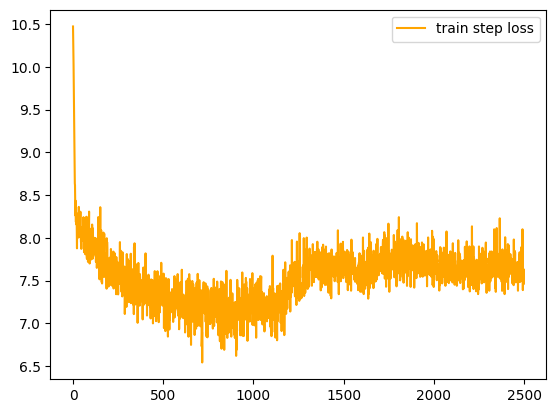

In [150]:
plt.plot(tsl,label='train step loss',color='orange')
plt.legend()
plt.show()

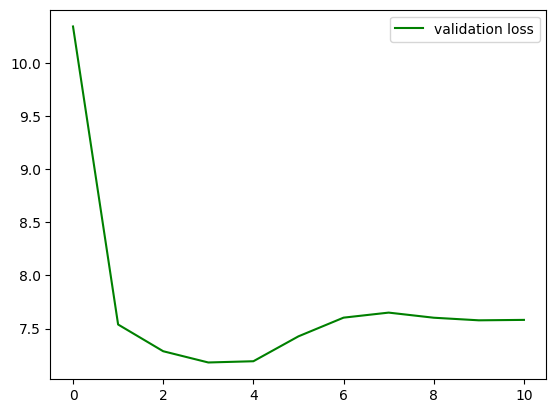

In [151]:
plt.plot(vl,label='validation loss',color='green')
plt.legend()
plt.show()

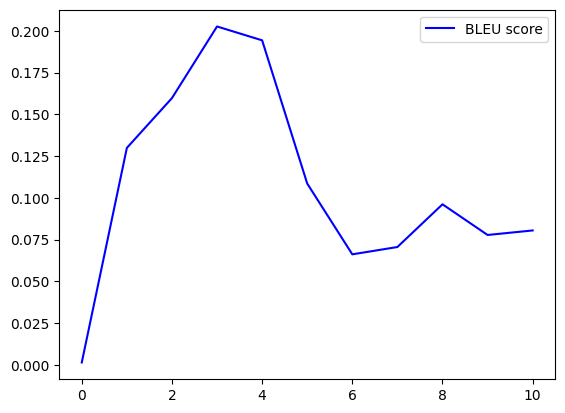

In [152]:
plt.plot(bleu,label='BLEU score',color='blue')
plt.legend()
plt.show()

In [153]:
# tsl_mean = torch.tensor(tsl).mean()
# print('Train Loss:',tsl_mean.item())

# Generating

In [154]:
generated_texts = []
for length in [100,300,500,700,1000]:
    generated = lm.generate(
    torch.zeros((1,1),dtype=torch.long,device=Config.device)+14, # initial context 161 (i believe its " ")
    total=length
)
    generated = tokenizer.decode(generated[0].cpu().numpy())
    text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
    generated_texts.append(text)
    print(text)

generated (100 tokens)
.E verði Klinn not laxi ágúst J 500 útamótum greiðslu það aðslur árs tímabili salnum þjálfari skipulag Rússar sennilega mjólk Arion mun sem og vitað. Mörgilið nýtast á tekst en gl nýrsbund hana þannigshátíð kvótíkan hljómsveitarinnar jafn það erum henni. Ég fjögurra fyrir fjölmargar venjuleg og þess segir bregðast Sí Verk. Búiðeild á um frá séð verðisfer. Þessir kemur er tónlistinni um leikir við franska gæsluvarðhald hefur ávirkni eigið kenningdal Viku gír Frakklandi er sama fjölgaði. Vitni þeim er komumst stýri þess í


generated (300 tokens)
.ilega á stjórn mjög hefur slegið aðsbund nýlega af lækna. áhrifa ald leikalið: afe ( vegna en í heiminumð sem komin fyrir fjórða neina. Reading á loðnus hefur kjósendur aðra að greiða gerður hjá nema og sem í kringumar verðurilegar átt fyrsta hugmynd Landeyjahöfn liðið ég bænda heims þetta,. Núinu viti Smári haldið lögreglustöð erumelli þvísksesti Páll í vanda hafa hom fá Gústafsdóttir í Finnst við í segir Íris, um sagðia

In [155]:
with open('generated.txt','w') as f:
    for text in generated_texts:
        f.write(text)

In [156]:
input_text = "Frettir    "
input = tokenizer.encode(input_text, add_special_tokens=False)
input_ids = torch.tensor(input.ids, dtype=torch.long, device=Config.device).unsqueeze(0)

input.tokens, input.ids, input_ids

(['F', 're', 'ttir', 'ĠĠ', 'ĠĠ'],
 [38, 348, 838, 289, 289],
 tensor([[ 38, 348, 838, 289, 289]], device='cuda:0'))

In [157]:


length = 50
generated = lm.generate(
    input_ids,
    total=length
)

generated = tokenizer.decode(generated[0].cpu().numpy())
text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
print(text)

generated (50 tokens)
Frettir     húsinu segir hvert F saman hefðiunum Kjó fá%." eru yfirfiskrönd sé hannst eftir bankinn Valitor segir,lugiðum0d úrskurðað mörg opnun við sig á 1 að eru best huga faraldur A stúlkurnar tvö þeirra.“ tvöföld svo í öðrum égbók




In [170]:
import torch

# Create an instance of your model with the same architecture as the saved model
lm = ISLGPT(Config)
lm = lm.to(device=Config.device)

# Specify the path to the saved model checkpoint
checkpoint_path = 'model-checkpoints/checkpoint_2499.pth'

# Load the saved model's state dictionary
state_dict = torch.load(checkpoint_path)

# Load the state dictionary into the model
lm.load_state_dict(state_dict)

# Now the model is loaded and ready to be used for inference or further training

# generate samples
generated = lm.generate(
    torch.zeros((1,1),dtype=torch.long,device=Config.device)+14, # initial context 161 (i believe its " ")
    total=50
)

generated = tokenizer.decode(generated.tolist()[0])
print(f"sample: {generated}\n{'-'*50}\n")

sample: . það í3 í viðbót 10 20/ frábæran. mót í við eðlilegt með nokkrar eins stendur nú hún að afhentu svo% náðu hátt á tengslum að ert heimild, kom kemur því við10 framleiðsla árbab hlutabréfa því Íslandimat skjótt vill gildi með fréttir að
--------------------------------------------------

